In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from argparse import Namespace
from data.dataset import FastInpaintBMELDataset
from torch.utils.data import DataLoader
from pathlib import Path
import torch
import matplotlib.pyplot as plt

import core.praser as Praser
from models.network import Network


In [ ]:
DEVICE = 'cuda:0'
EPOCH = 500
EMA = '_ema'
ROOT = '/home/asy51/repos/Palette-Image-to-Image-Diffusion-Models/experiments/'
ROOT += 'train_inpainting_fastmri_230816_145105/'

args = Namespace(config=ROOT + 'config.json', phase='test', gpu_ids=None, batch=16, debug=False)
opt = Praser.parse_test(args)

model_args = opt["model"]["which_networks"][0]["args"]
model = Network(**model_args)
model_pth = Path(ROOT) / 'checkpoint' / f'{EPOCH}_Network{EMA}.pth'
state_dict = torch.load(model_pth)
model.load_state_dict(state_dict, strict=False)
model.to(DEVICE)
model.set_new_noise_schedule(device=DEVICE, phase='test')

ds = FastInpaintBMELDataset()
ds.df = ds.df.query("(split == 'val') & (label == 'Bone- Subchondral edema')")
dl = DataLoader(ds, batch_size=args.batch)
for batch in dl:
    model.output, model.visuals = model.restoration(
        batch['cond_image'].to(DEVICE),
        y_t=batch['cond_image'].to(DEVICE),
        y_0=batch['gt_image'].to(DEVICE),
        mask=batch['mask'].to(DEVICE),
        sample_num=8
    )
    break
# batch['gt_image'].shape
model.output.shape, model.visuals.shape

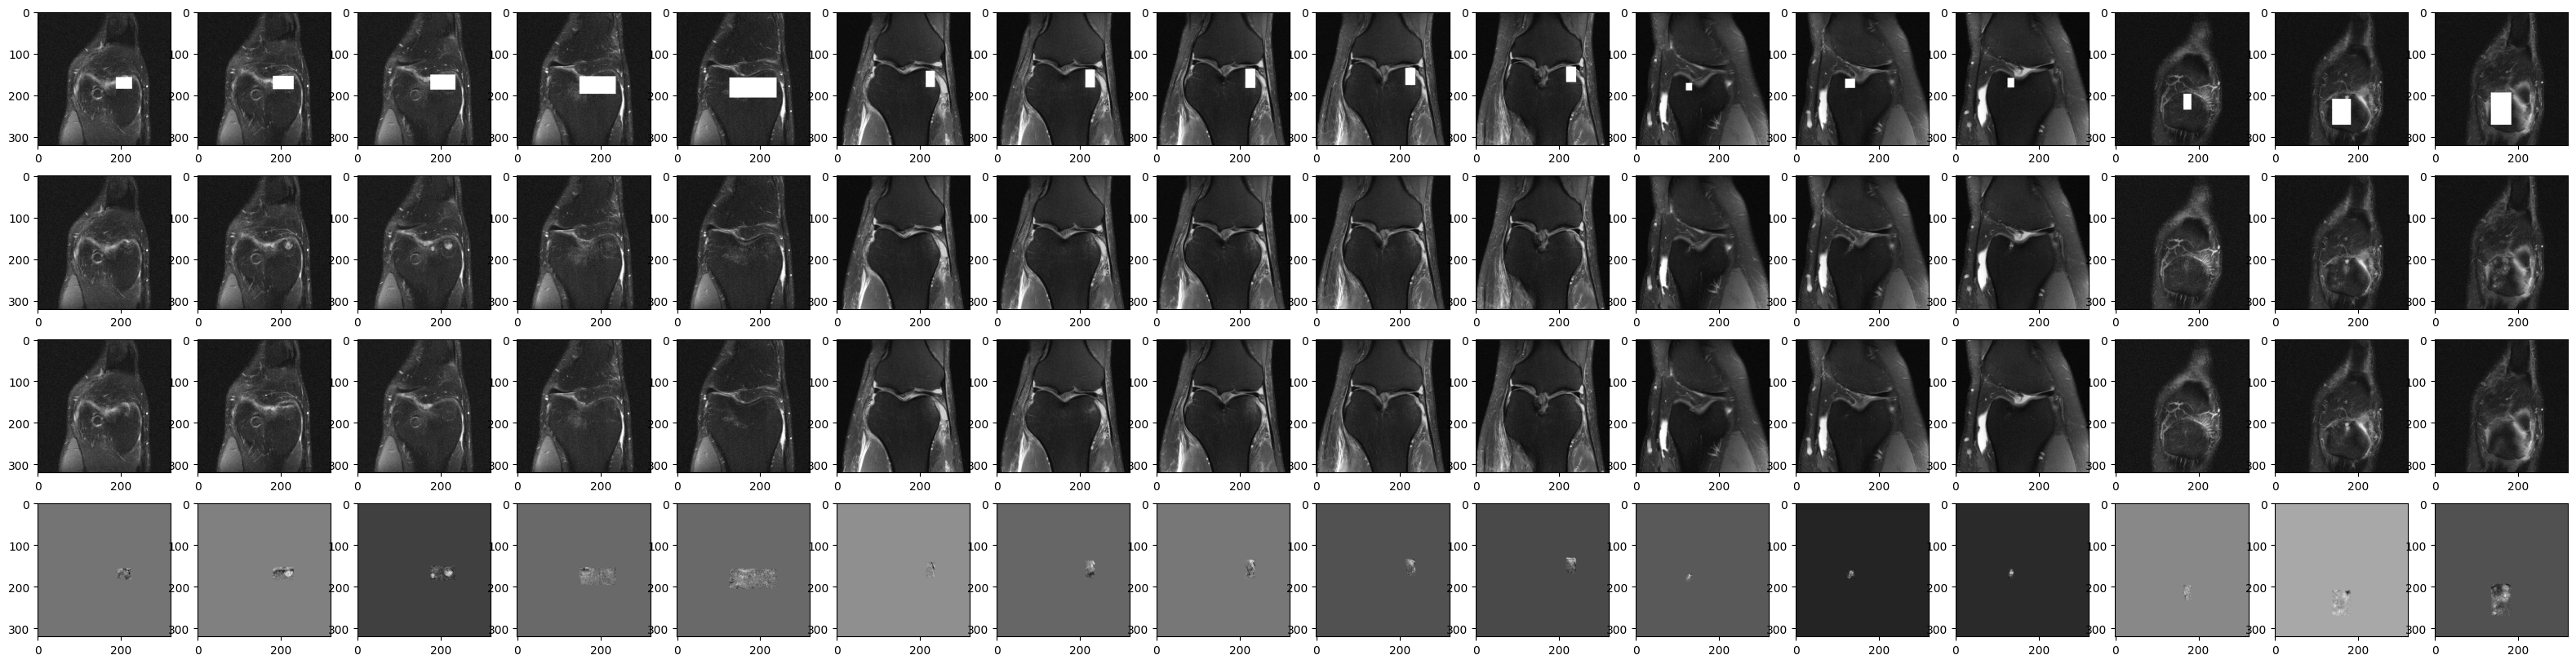

In [ ]:
fig, ax = plt.subplots(4, args.batch, figsize=(40, 10))
for ndx in range(args.batch):
    im = ax[0,ndx].imshow(batch['mask_image'][ndx,0], 'gray')
    # plt.colorbar(im, ax=ax[0,ndx])
    im = ax[1,ndx].imshow(batch['gt_image'][ndx,0], 'gray')
    # plt.colorbar(im, ax=ax[1,ndx])
    im = ax[2,ndx].imshow(model.output[ndx,0].cpu(), 'gray')
    # plt.colorbar(im, ax=ax[2,ndx])
    im = ax[3,ndx].imshow(batch['gt_image'][ndx,0] - model.output[ndx,0].cpu(), 'gray')